## Librerias 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from lib.LCWavelet import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import optuna

## Arquitectura del modelo

In [2]:
class ShallueModel(nn.Module):
    def __init__(self, global_size=2001, local_size=201, num_classes=2):
        super(ShallueModel, self).__init__()
        self.global_size = global_size
        self.local_size = local_size
        self.num_classes = num_classes
        if num_classes == 1:
            print("Binary classification, sigmoid activation will be used.")
        elif num_classes > 1:
            print("Multi-class classification, softmax activation will be used.")
            
        
        self.conv_global_odd = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
        
        self.conv_global_even = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
        
        self.conv_local_odd = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )
        
        self.conv_local_even = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )
        
        # Calcular automáticamente el número de features resultantes de la concatenación
        with torch.no_grad():
            dummy_global = torch.zeros(1, 1, self.global_size)
            dummy_local = torch.zeros(1, 1, self.local_size)
            out_global_odd  = self.conv_global_odd(dummy_global)
            out_global_even = self.conv_global_even(dummy_global)
            out_local_odd   = self.conv_local_odd(dummy_local)
            out_local_even  = self.conv_local_even(dummy_local)
            
            # Flatten cada salida y sumar sus dimensiones
            num_features = out_global_odd.view(1, -1).size(1) + \
                           out_global_even.view(1, -1).size(1) + \
                           out_local_odd.view(1, -1).size(1) + \
                           out_local_even.view(1, -1).size(1)
            
        print("Número de features concatenados:", num_features)
        
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inputs):
        global_odd = self.conv_global_odd(inputs[0])
        global_even = self.conv_global_even(inputs[1])
        local_odd = self.conv_local_odd(inputs[2])
        local_even = self.conv_local_even(inputs[3])
        
        global_odd = global_odd.view(global_odd.size(0), -1)
        global_even = global_even.view(global_even.size(0), -1)
        local_odd = local_odd.view(local_odd.size(0), -1)
        local_even = local_even.view(local_even.size(0), -1)
        
        # Concatenación de todas las ramas
        x = torch.cat((global_odd, global_even, local_odd, local_even), dim=1)
        x = self.fc(x)
        if self.num_classes > 1:
            return F.softmax(x, dim=1)
        else:
            return x
    

## Cargado de datos

In [3]:
def load_data(path, file_name):
    lc = LightCurveWaveletGlobalLocalCollection.from_pickle(path + file_name)
    try:
        getattr(lc, 'levels')
    except AttributeError:
        lc.levels = [1, 2, 3, 4]
    return lc
        
path='all_data/'
files = os.listdir(path)
kepler_files = [f for f in files if f.endswith('.pickle')]
light_curves = []

for file in tqdm(kepler_files, desc='Loading data'):
    light_curves.append(load_data(path, file))

Loading data:   0%|          | 0/9346 [00:00<?, ?it/s]

Loading data: 100%|██████████| 9346/9346 [02:52<00:00, 54.27it/s]


### Separar entre los confirmados y candidatos

In [4]:
candidates = [lc for lc in light_curves if lc.headers['class'] == 'CANDIDATE']
print("Número de candidatos:", len(candidates))

confirmed = [lc for lc in light_curves if lc.headers['class'] == 'CONFIRMED' or lc.headers['class'] == 'FALSE POSITIVE']
print("Número de confirmados:", len(confirmed))

classes = [lc.headers['class'] for lc in confirmed]
classes = set(classes)
classes = {v: k for k, v in enumerate(classes)}
print("Clases:", classes)

Número de candidatos: 2046
Número de confirmados: 7300
Clases: {'FALSE POSITIVE': 0, 'CONFIRMED': 1}


In [5]:
global_odd = []
global_even = []
local_odd = []
local_even = []
labels = []

for lc in tqdm(confirmed, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)
    # Convertir la clase a un número entero
    labels.append(classes[lc.headers['class']])
    
print("Número de datos:", len(global_odd))
print('Elementos de cada clase:', {k: labels.count(k) for k in set(labels)})


Processing light curves: 100%|██████████| 7300/7300 [00:00<00:00, 87192.71it/s]

Número de datos: 7300
Elementos de cada clase: {0: 4637, 1: 2663}


#### Ajustar los datos para que sean equiprobables (data augmentation)

In [18]:
# Ajustar el numero de elementos de cada clase
min_class_size = min([list(labels).count(i) for i in set(labels)])
max_class_size = max([list(labels).count(i) for i in set(labels)])
min_class = min([i for i in set(labels) if list(labels).count(i) == min_class_size])
max_class = max([i for i in set(labels) if list(labels).count(i) == max_class_size])
print("Tamaño máximo de clase:", max_class_size)
print("Tamaño mínimo de clase:", min_class_size)

# coger los datos de la clase con menos elementos y generar un dato nuevo dandole la vuelta a la señal hasta que tenga el mismo número de elementos que la clase con más elementos
for i in range(len(labels)):
    if labels[i] == min_class: # clase con menos elementos
        global_odd.append(global_odd[i][::-1])
        global_even.append(global_even[i][::-1])
        local_odd.append(local_odd[i][::-1])
        local_even.append(local_even[i][::-1])
        labels.append(labels[i])
    if labels[i] == max_class and labels.count(max_class) < min_class_size*2: # clase con más elementos
        global_odd.append(global_odd[i][::-1])
        global_even.append(global_even[i][::-1])
        local_odd.append(local_odd[i][::-1])
        local_even.append(local_even[i][::-1])
        labels.append(labels[i])
        
print("Número de datos tras ajuste:", len(global_odd))
print('Elementos de cada clase tras ajuste:', {k: list(labels).count(k) for k in set(labels)})


Tamaño máximo de clase: 4637
Tamaño mínimo de clase: 2663
Número de datos tras ajuste: 10652
Elementos de cada clase tras ajuste: {0: 5326, 1: 5326}


### Separar las muestras en train y test

In [19]:
items = []

for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global_odd': global_odd[i],
        'global_even': global_even[i],
        'local_odd': local_odd[i],
        'local_even': local_even[i],
        'label': labels[i]
    }
    items.append(item)

# train, test = train_test_split(items, test_size=0.3, random_state=42)
train, test = train_test_split(items, test_size=0.3)
train_global_odd = torch.tensor([item['global_odd'] for item in train])
train_global_even = torch.tensor([item['global_even'] for item in train])
train_local_odd = torch.tensor([item['local_odd'] for item in train])
train_local_even = torch.tensor([item['local_even'] for item in train])
train_labels = torch.tensor([item['label'] for item in train])

test_global_odd = torch.tensor([item['global_odd'] for item in test])
test_global_even = torch.tensor([item['global_even'] for item in test])
test_local_odd = torch.tensor([item['local_odd'] for item in test])
test_local_even = torch.tensor([item['local_even'] for item in test])
test_labels = torch.tensor([item['label'] for item in test])

train_dataset = torch.utils.data.TensorDataset(train_global_odd, train_global_even, train_local_odd, train_local_even, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_global_odd, test_global_even, test_local_odd, test_local_even, test_labels)

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Creating items: 100%|██████████| 10652/10652 [00:00<00:00, 2634610.58it/s]


Tamaño del conjunto de entrenamiento: 7456
Tamaño del conjunto de prueba: 3196


## Entrenar el modelo

#### Definir device en caso de usar GPU o CPU

In [7]:
try:
    import torch_directml
    if torch_directml.is_available():
        device = torch_directml.device()
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)

Dispositivo: privateuseone:0


In [23]:
batch_size = 64
num_epochs = 100
learning_rate = 0.0001
l1_penalty = 1e-6 #1e-5 #0.003199
l2_penalty = 1e-4 #0.003380
dropout = 0.006516
fraction = max_class_size / min_class_size
# fraction = 0.9
print("Fracción:", fraction)
fraction = torch.tensor(5, device=device) #torch.tensor(0.9342, device=device) # peso positivo para la función de pérdida BCEWithLogitsLoss
n_classes = 1 # si pones 1 usa sigmoid, si pones >1 usa softmax
if n_classes > 1:
    loss_fn = nn.CrossEntropyLoss() # para clasificación multiclase
else:
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=fraction) # para clasificación binaria con sigmoid
    
model = ShallueModel(global_size=2001, local_size=201, num_classes=n_classes).to(device)
if input("¿Quieres inicializar el modelo? (s/n): ").lower() == 's':  
    try: 
        model.load_state_dict(torch.load('models/Shallue_model.pth'))
        model.eval()
    except:
        print("No se pudo cargar el modelo. Se inicializa uno nuevo.")


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)
schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Fracción: 1.7412692452121667
Binary classification, sigmoid activation will be used.
Número de features concatenados: 28672


In [10]:
def train_fn(model, train_loader, optimizer, loss_fn):
    model.train()
    train_size = len(train_loader.dataset)
    n_batches = len(train_loader)
    total_loss = 0.0
    correct = 0
    for batch, data in enumerate(tqdm(train_loader, desc='Training')):
        global_odd, global_even, local_odd, local_even, labels = data
        # check if any tensor is empty
        if global_odd.numel() == 0 or global_even.numel() == 0 or local_odd.numel() == 0 or local_even.numel() == 0:
            continue
        # check if any tensor has nan
        if torch.isnan(global_odd).any() or torch.isnan(global_even).any() or torch.isnan(local_odd).any() or torch.isnan(local_even).any():
            continue
        # Move data to device
        global_odd = global_odd.to(device).unsqueeze(1).float()
        global_even = global_even.to(device).unsqueeze(1).float()
        local_odd = local_odd.to(device).unsqueeze(1).float()
        local_even = local_even.to(device).unsqueeze(1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward propagation
        outputs = model((global_odd, global_even, local_odd, local_even))
        
        if type(loss_fn) == nn.BCEWithLogitsLoss:
            # elimnar la dimensión extra de outputs
            outputs = outputs.squeeze(1)
            labels = labels.float()
        # Compute loss and backpropagation
        l1 = 0
        for param in model.parameters():
            l1 += torch.sum(torch.abs(param))
            
        loss = loss_fn(outputs, labels)
        loss = loss + l1_penalty * l1
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if type(loss_fn) == nn.BCEWithLogitsLoss:
            predicted = (outputs > 0.5).float()
        else:
            _, predicted = torch.max(outputs.data, 1)
            
        correct += (predicted == labels).sum().item()

    accuracy = correct / train_size
    train_loss = total_loss / n_batches
        
    return train_loss, accuracy


def val_fn(model, test_loader, loss_fn):
    model.eval()
    test_size = len(test_loader.dataset)
    n_batches = len(test_loader)
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch, data in enumerate(tqdm(test_loader, desc='Validation')):
            global_odd, global_even, local_odd, local_even, labels = data
            # check if any tensor is empty
            if global_odd.numel() == 0 or global_even.numel() == 0 or local_odd.numel() == 0 or local_even.numel() == 0:
                test_size -= 1
                continue
            # check if any tensor has nan
            if torch.isnan(global_odd).any() or torch.isnan(global_even).any() or torch.isnan(local_odd).any() or torch.isnan(local_even).any():
                test_size -= 1
                continue
            
            # Move data to device
            global_odd = global_odd.to(device).unsqueeze(1).float()
            global_even = global_even.to(device).unsqueeze(1).float()
            local_odd = local_odd.to(device).unsqueeze(1).float()
            local_even = local_even.to(device).unsqueeze(1).float()
            labels = labels.to(device)
            
            outputs = model((global_odd, global_even, local_odd, local_even))
            if type(loss_fn) == nn.BCEWithLogitsLoss:
            # elimnar la dimensión extra de outputs
                outputs = outputs.squeeze(1)
                labels = labels.float()

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            if type(loss_fn) == nn.BCEWithLogitsLoss:
                predicted = (outputs > 0.5).float()
            else:
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    accuracy = correct / test_size
    val_loss = total_loss / n_batches
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return val_loss, accuracy, f1, precision, recall

In [ ]:

prev_val_loss = float('inf')
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}', '------'*20)
    train_loss, train_accuracy = train_fn(model, train_loader, optimizer, loss_fn)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    val_loss, val_accuracy, f1, precision, recall = val_fn(model, test_loader, loss_fn)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    schedule.step(val_loss)
    
    # early stopping
    # if epoch > 25 and val_loss > prev_val_loss:
    #     print("Early stopping")
    #     break
    prev_val_loss = val_loss

print("Entrenamiento y validación completados.", '------'*20)

Epoch 1/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.81it/s]


Train Loss: 1.4018, Train Accuracy: 0.4826


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.40it/s]


Validation Loss: 1.2809, Validation Accuracy: 0.4955
F1 Score: 0.3481, Precision: 0.7132, Recall: 0.5054
Epoch 2/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.57it/s]


Train Loss: 1.1893, Train Accuracy: 0.5652


Validation: 100%|██████████| 50/50 [00:00<00:00, 97.26it/s]


Validation Loss: 1.1086, Validation Accuracy: 0.6207
F1 Score: 0.5906, Precision: 0.7302, Recall: 0.6331
Epoch 3/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.66it/s]


Train Loss: 1.0931, Train Accuracy: 0.6155


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.92it/s]


Validation Loss: 1.0698, Validation Accuracy: 0.6207
F1 Score: 0.5839, Precision: 0.7557, Recall: 0.6331
Epoch 4/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.52it/s]


Train Loss: 1.0731, Train Accuracy: 0.6249


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.83it/s]


Validation Loss: 1.0562, Validation Accuracy: 0.6560
F1 Score: 0.6433, Precision: 0.7404, Recall: 0.6692
Epoch 5/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.44it/s]


Train Loss: 1.0455, Train Accuracy: 0.6383


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.56it/s]


Validation Loss: 1.0344, Validation Accuracy: 0.6701
F1 Score: 0.6616, Precision: 0.7495, Recall: 0.6836
Epoch 6/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.51it/s]


Train Loss: 0.9991, Train Accuracy: 0.6502


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.54it/s]


Validation Loss: 1.0123, Validation Accuracy: 0.6347
F1 Score: 0.6025, Precision: 0.7727, Recall: 0.6475
Epoch 7/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.60it/s]


Train Loss: 0.9904, Train Accuracy: 0.6520


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.99it/s]


Validation Loss: 0.9850, Validation Accuracy: 0.6676
F1 Score: 0.6536, Precision: 0.7669, Recall: 0.6810
Epoch 8/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.61it/s]


Train Loss: 0.9590, Train Accuracy: 0.6626


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.46it/s]


Validation Loss: 0.9837, Validation Accuracy: 0.6995
F1 Score: 0.6982, Precision: 0.7698, Recall: 0.7136
Epoch 9/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.55it/s]


Train Loss: 0.9333, Train Accuracy: 0.6714


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.52it/s]


Validation Loss: 0.9700, Validation Accuracy: 0.6767
F1 Score: 0.6641, Precision: 0.7785, Recall: 0.6903
Epoch 10/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.64it/s]


Train Loss: 0.9342, Train Accuracy: 0.6740


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.68it/s]


Validation Loss: 1.0008, Validation Accuracy: 0.6701
F1 Score: 0.6577, Precision: 0.7651, Recall: 0.6836
Epoch 11/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.65it/s]


Train Loss: 0.9208, Train Accuracy: 0.6786


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.48it/s]


Validation Loss: 0.9543, Validation Accuracy: 0.6748
F1 Score: 0.6627, Precision: 0.7728, Recall: 0.6884
Epoch 12/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.59it/s]


Train Loss: 0.9195, Train Accuracy: 0.6776


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.26it/s]


Validation Loss: 0.9891, Validation Accuracy: 0.6610
F1 Score: 0.6434, Precision: 0.7691, Recall: 0.6743
Epoch 13/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.48it/s]


Train Loss: 0.8872, Train Accuracy: 0.6949


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.72it/s]


Validation Loss: 0.9354, Validation Accuracy: 0.7008
F1 Score: 0.6961, Precision: 0.7868, Recall: 0.7149
Epoch 14/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.29it/s]


Train Loss: 0.8689, Train Accuracy: 0.7047


Validation: 100%|██████████| 50/50 [00:00<00:00, 96.48it/s]


Validation Loss: 0.9049, Validation Accuracy: 0.7158
F1 Score: 0.7160, Precision: 0.7890, Recall: 0.7302
Epoch 15/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s]


Train Loss: 0.8428, Train Accuracy: 0.7166


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.96it/s]


Validation Loss: 0.9302, Validation Accuracy: 0.7208
F1 Score: 0.7250, Precision: 0.7782, Recall: 0.7353
Epoch 16/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s]


Train Loss: 0.8379, Train Accuracy: 0.7209


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.67it/s]


Validation Loss: 0.8783, Validation Accuracy: 0.7199
F1 Score: 0.7197, Precision: 0.7979, Recall: 0.7344
Epoch 17/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.37it/s]


Train Loss: 0.8067, Train Accuracy: 0.7339


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.40it/s]


Validation Loss: 0.8766, Validation Accuracy: 0.7452
F1 Score: 0.7522, Precision: 0.8000, Recall: 0.7602
Epoch 18/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.27it/s]


Train Loss: 0.8043, Train Accuracy: 0.7394


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.17it/s]


Validation Loss: 0.8595, Validation Accuracy: 0.7321
F1 Score: 0.7347, Precision: 0.8034, Recall: 0.7468
Epoch 19/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.26it/s]


Train Loss: 0.8263, Train Accuracy: 0.7276


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.61it/s]


Validation Loss: 0.8894, Validation Accuracy: 0.7618
F1 Score: 0.7723, Precision: 0.8035, Recall: 0.7771
Epoch 20/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.44it/s]


Train Loss: 0.7869, Train Accuracy: 0.7445


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.21it/s]


Validation Loss: 0.9331, Validation Accuracy: 0.7202
F1 Score: 0.7223, Precision: 0.7869, Recall: 0.7347
Epoch 21/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.38it/s]


Train Loss: 0.7701, Train Accuracy: 0.7454


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.57it/s]


Validation Loss: 0.8559, Validation Accuracy: 0.7568
F1 Score: 0.7656, Precision: 0.8062, Recall: 0.7720
Epoch 22/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.35it/s]


Train Loss: 0.7654, Train Accuracy: 0.7521


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.31it/s]


Validation Loss: 0.9394, Validation Accuracy: 0.7196
F1 Score: 0.7200, Precision: 0.7942, Recall: 0.7340
Epoch 23/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.35it/s]


Train Loss: 0.7545, Train Accuracy: 0.7555


Validation: 100%|██████████| 50/50 [00:00<00:00, 92.50it/s]


Validation Loss: 0.8489, Validation Accuracy: 0.7549
F1 Score: 0.7628, Precision: 0.8090, Recall: 0.7701
Epoch 24/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.27it/s]


Train Loss: 0.7348, Train Accuracy: 0.7602


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.33it/s]


Validation Loss: 0.8632, Validation Accuracy: 0.7674
F1 Score: 0.7776, Precision: 0.8135, Recall: 0.7829
Epoch 25/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.34it/s]


Train Loss: 0.7168, Train Accuracy: 0.7673


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.38it/s]


Validation Loss: 0.8586, Validation Accuracy: 0.7346
F1 Score: 0.7362, Precision: 0.8130, Recall: 0.7494
Epoch 26/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.43it/s]


Train Loss: 0.7115, Train Accuracy: 0.7711


Validation: 100%|██████████| 50/50 [00:00<00:00, 96.17it/s]


Validation Loss: 0.8346, Validation Accuracy: 0.7452
F1 Score: 0.7506, Precision: 0.8090, Recall: 0.7602
Epoch 27/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.31it/s]


Train Loss: 0.6884, Train Accuracy: 0.7776


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.97it/s]


Validation Loss: 0.8418, Validation Accuracy: 0.7621
F1 Score: 0.7710, Precision: 0.8140, Recall: 0.7775
Epoch 28/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.40it/s]


Train Loss: 0.6623, Train Accuracy: 0.7888


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.75it/s]


Validation Loss: 1.0177, Validation Accuracy: 0.7690
F1 Score: 0.7825, Precision: 0.7958, Recall: 0.7845
Epoch 29/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.50it/s]


Train Loss: 0.6680, Train Accuracy: 0.7830


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.54it/s]


Validation Loss: 0.8582, Validation Accuracy: 0.7628
F1 Score: 0.7716, Precision: 0.8150, Recall: 0.7781
Epoch 30/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.42it/s]


Train Loss: 0.6230, Train Accuracy: 0.7976


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.85it/s]


Validation Loss: 0.9149, Validation Accuracy: 0.7803
F1 Score: 0.7938, Precision: 0.8096, Recall: 0.7960
Epoch 31/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.45it/s]


Train Loss: 0.6085, Train Accuracy: 0.8023


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.98it/s]


Validation Loss: 0.8909, Validation Accuracy: 0.7894
F1 Score: 0.8032, Precision: 0.8188, Recall: 0.8052
Epoch 32/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.41it/s]


Train Loss: 0.5840, Train Accuracy: 0.8129


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.20it/s]


Validation Loss: 0.8963, Validation Accuracy: 0.7790
F1 Score: 0.7913, Precision: 0.8162, Recall: 0.7947
Epoch 00032: reducing learning rate of group 0 to 5.0000e-05.
Epoch 33/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.33it/s]


Train Loss: 0.5280, Train Accuracy: 0.8294


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.98it/s]


Validation Loss: 0.9434, Validation Accuracy: 0.7897
F1 Score: 0.8039, Precision: 0.8167, Recall: 0.8056
Epoch 34/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.28it/s]


Train Loss: 0.5127, Train Accuracy: 0.8330


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.09it/s]


Validation Loss: 0.8879, Validation Accuracy: 0.7809
F1 Score: 0.7927, Precision: 0.8213, Recall: 0.7966
Epoch 35/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.35it/s]


Train Loss: 0.4900, Train Accuracy: 0.8385


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.45it/s]


Validation Loss: 0.9553, Validation Accuracy: 0.7853
F1 Score: 0.7990, Precision: 0.8146, Recall: 0.8011
Epoch 36/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.34it/s]


Train Loss: 0.4719, Train Accuracy: 0.8468


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.16it/s]


Validation Loss: 0.9476, Validation Accuracy: 0.7862
F1 Score: 0.7998, Precision: 0.8166, Recall: 0.8020
Epoch 37/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.31it/s]


Train Loss: 0.4595, Train Accuracy: 0.8491


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.86it/s]


Validation Loss: 0.9865, Validation Accuracy: 0.7884
F1 Score: 0.8017, Precision: 0.8213, Recall: 0.8043
Epoch 38/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.30it/s]


Train Loss: 0.4503, Train Accuracy: 0.8498


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.96it/s]


Validation Loss: 1.1452, Validation Accuracy: 0.7950
F1 Score: 0.8100, Precision: 0.8177, Recall: 0.8110
Epoch 00038: reducing learning rate of group 0 to 2.5000e-05.
Epoch 39/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.35it/s]


Train Loss: 0.4077, Train Accuracy: 0.8663


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.56it/s]


Validation Loss: 1.2811, Validation Accuracy: 0.7922
F1 Score: 0.8077, Precision: 0.8109, Recall: 0.8081
Epoch 40/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.39it/s]


Train Loss: 0.3956, Train Accuracy: 0.8696


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.68it/s]


Validation Loss: 1.1590, Validation Accuracy: 0.7915
F1 Score: 0.8064, Precision: 0.8146, Recall: 0.8075
Epoch 41/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.37it/s]


Train Loss: 0.3780, Train Accuracy: 0.8746


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.00it/s]


Validation Loss: 1.2052, Validation Accuracy: 0.7925
F1 Score: 0.8075, Precision: 0.8147, Recall: 0.8084
Epoch 42/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.31it/s]


Train Loss: 0.3678, Train Accuracy: 0.8766


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.74it/s]


Validation Loss: 1.5087, Validation Accuracy: 0.7919
F1 Score: 0.8075, Precision: 0.8096, Recall: 0.8078
Epoch 43/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.25it/s]


Train Loss: 0.3686, Train Accuracy: 0.8763


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.54it/s]


Validation Loss: 1.2247, Validation Accuracy: 0.7922
F1 Score: 0.8069, Precision: 0.8162, Recall: 0.8081
Epoch 44/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.21it/s]


Train Loss: 0.3614, Train Accuracy: 0.8784


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.69it/s]


Validation Loss: 1.3315, Validation Accuracy: 0.7903
F1 Score: 0.8054, Precision: 0.8113, Recall: 0.8062
Epoch 00044: reducing learning rate of group 0 to 1.2500e-05.
Epoch 45/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.25it/s]


Train Loss: 0.3342, Train Accuracy: 0.8851


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.38it/s]


Validation Loss: 1.4936, Validation Accuracy: 0.7865
F1 Score: 0.8020, Precision: 0.8050, Recall: 0.8024
Epoch 46/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.23it/s]


Train Loss: 0.3290, Train Accuracy: 0.8875


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.08it/s]


Validation Loss: 1.4409, Validation Accuracy: 0.7890
F1 Score: 0.8043, Precision: 0.8090, Recall: 0.8049
Epoch 47/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.23it/s]


Train Loss: 0.3277, Train Accuracy: 0.8869


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.33it/s]


Validation Loss: 1.4767, Validation Accuracy: 0.7859
F1 Score: 0.8012, Precision: 0.8053, Recall: 0.8017
Epoch 48/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.24it/s]


Train Loss: 0.3231, Train Accuracy: 0.8879


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.30it/s]


Validation Loss: 1.5014, Validation Accuracy: 0.7900
F1 Score: 0.8054, Precision: 0.8093, Recall: 0.8059
Epoch 49/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.30it/s]


Train Loss: 0.3174, Train Accuracy: 0.8899


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.25it/s]


Validation Loss: 1.5395, Validation Accuracy: 0.7894
F1 Score: 0.8048, Precision: 0.8084, Recall: 0.8052
Epoch 50/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s]


Train Loss: 0.3163, Train Accuracy: 0.8910


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.27it/s]


Validation Loss: 1.4311, Validation Accuracy: 0.7872
F1 Score: 0.8022, Precision: 0.8084, Recall: 0.8030
Epoch 00050: reducing learning rate of group 0 to 6.2500e-06.
Epoch 51/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s]


Train Loss: 0.3015, Train Accuracy: 0.8950


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.59it/s]


Validation Loss: 1.5789, Validation Accuracy: 0.7887
F1 Score: 0.8041, Precision: 0.8077, Recall: 0.8046
Epoch 52/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.25it/s]


Train Loss: 0.2992, Train Accuracy: 0.8989


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.88it/s]


Validation Loss: 1.4475, Validation Accuracy: 0.7900
F1 Score: 0.8052, Precision: 0.8107, Recall: 0.8059
Epoch 53/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.29it/s]


Train Loss: 0.2990, Train Accuracy: 0.8948


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.20it/s]


Validation Loss: 1.6651, Validation Accuracy: 0.7881
F1 Score: 0.8036, Precision: 0.8061, Recall: 0.8040
Epoch 54/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.21it/s]


Train Loss: 0.2959, Train Accuracy: 0.8965


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.77it/s]


Validation Loss: 1.6132, Validation Accuracy: 0.7894
F1 Score: 0.8048, Precision: 0.8084, Recall: 0.8052
Epoch 55/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.23it/s]


Train Loss: 0.2926, Train Accuracy: 0.8971


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.62it/s]


Validation Loss: 1.5887, Validation Accuracy: 0.7884
F1 Score: 0.8038, Precision: 0.8077, Recall: 0.8043
Epoch 56/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.14it/s]


Train Loss: 0.2937, Train Accuracy: 0.9048


Validation: 100%|██████████| 50/50 [00:00<00:00, 96.31it/s]


Validation Loss: 1.6194, Validation Accuracy: 0.7894
F1 Score: 0.8048, Precision: 0.8084, Recall: 0.8052
Epoch 00056: reducing learning rate of group 0 to 3.1250e-06.
Epoch 57/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.28it/s]


Train Loss: 0.2794, Train Accuracy: 0.9001


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.13it/s]


Validation Loss: 1.6933, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8050, Recall: 0.8027
Epoch 58/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.19it/s]


Train Loss: 0.2865, Train Accuracy: 0.8989


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.63it/s]


Validation Loss: 1.5691, Validation Accuracy: 0.7900
F1 Score: 0.8053, Precision: 0.8101, Recall: 0.8059
Epoch 59/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.26it/s]


Train Loss: 0.2872, Train Accuracy: 0.8987


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.87it/s]


Validation Loss: 1.6029, Validation Accuracy: 0.7884
F1 Score: 0.8037, Precision: 0.8081, Recall: 0.8043
Epoch 60/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.19it/s]


Train Loss: 0.2812, Train Accuracy: 0.9002


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.87it/s]


Validation Loss: 1.6366, Validation Accuracy: 0.7890
F1 Score: 0.8044, Precision: 0.8083, Recall: 0.8049
Epoch 61/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.04it/s]


Train Loss: 0.2836, Train Accuracy: 0.9072


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.52it/s]


Validation Loss: 1.6545, Validation Accuracy: 0.7878
F1 Score: 0.8032, Precision: 0.8069, Recall: 0.8036
Epoch 62/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.22it/s]


Train Loss: 0.2808, Train Accuracy: 0.9006


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.04it/s]


Validation Loss: 1.7468, Validation Accuracy: 0.7862
F1 Score: 0.8017, Precision: 0.8043, Recall: 0.8020
Epoch 00062: reducing learning rate of group 0 to 1.5625e-06.
Epoch 63/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.28it/s]


Train Loss: 0.2754, Train Accuracy: 0.9016


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.88it/s]


Validation Loss: 1.6872, Validation Accuracy: 0.7887
F1 Score: 0.8042, Precision: 0.8076, Recall: 0.8046
Epoch 64/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.28it/s]


Train Loss: 0.2776, Train Accuracy: 0.9003


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.90it/s]


Validation Loss: 1.6935, Validation Accuracy: 0.7875
F1 Score: 0.8029, Precision: 0.8063, Recall: 0.8033
Epoch 65/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.14it/s]


Train Loss: 0.2773, Train Accuracy: 0.9006


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.65it/s]


Validation Loss: 1.7323, Validation Accuracy: 0.7865
F1 Score: 0.8020, Precision: 0.8048, Recall: 0.8024
Epoch 66/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.14it/s]


Train Loss: 0.2737, Train Accuracy: 0.9020


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.49it/s]


Validation Loss: 1.7230, Validation Accuracy: 0.7872
F1 Score: 0.8026, Precision: 0.8057, Recall: 0.8030
Epoch 67/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.18it/s]


Train Loss: 0.2728, Train Accuracy: 0.9010


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.23it/s]


Validation Loss: 1.7491, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8050, Recall: 0.8027
Epoch 68/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.19it/s]


Train Loss: 0.2765, Train Accuracy: 0.9001


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.00it/s]


Validation Loss: 1.7053, Validation Accuracy: 0.7878
F1 Score: 0.8032, Precision: 0.8065, Recall: 0.8036
Epoch 00068: reducing learning rate of group 0 to 7.8125e-07.
Epoch 69/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s]


Train Loss: 0.2719, Train Accuracy: 0.9021


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.59it/s]


Validation Loss: 1.7156, Validation Accuracy: 0.7881
F1 Score: 0.8035, Precision: 0.8069, Recall: 0.8040
Epoch 70/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.34it/s]


Train Loss: 0.2720, Train Accuracy: 0.9022


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.62it/s]


Validation Loss: 1.7453, Validation Accuracy: 0.7872
F1 Score: 0.8026, Precision: 0.8055, Recall: 0.8030
Epoch 71/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.39it/s]


Train Loss: 0.2738, Train Accuracy: 0.9021


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.32it/s]


Validation Loss: 1.7280, Validation Accuracy: 0.7878
F1 Score: 0.8033, Precision: 0.8062, Recall: 0.8036
Epoch 72/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.28it/s]


Train Loss: 0.2733, Train Accuracy: 0.9010


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.91it/s]


Validation Loss: 1.7326, Validation Accuracy: 0.7887
F1 Score: 0.8042, Precision: 0.8074, Recall: 0.8046
Epoch 73/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.21it/s]


Train Loss: 0.2729, Train Accuracy: 0.9020


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.81it/s]


Validation Loss: 1.7215, Validation Accuracy: 0.7890
F1 Score: 0.8045, Precision: 0.8079, Recall: 0.8049
Epoch 74/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.25it/s]


Train Loss: 0.2704, Train Accuracy: 0.9020


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.12it/s]


Validation Loss: 1.7411, Validation Accuracy: 0.7875
F1 Score: 0.8029, Precision: 0.8059, Recall: 0.8033
Epoch 00074: reducing learning rate of group 0 to 3.9063e-07.
Epoch 75/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.20it/s]


Train Loss: 0.2736, Train Accuracy: 0.9014


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.32it/s]


Validation Loss: 1.7431, Validation Accuracy: 0.7872
F1 Score: 0.8026, Precision: 0.8056, Recall: 0.8030
Epoch 76/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.22it/s]


Train Loss: 0.2736, Train Accuracy: 0.9013


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.12it/s]


Validation Loss: 1.7372, Validation Accuracy: 0.7878
F1 Score: 0.8032, Precision: 0.8063, Recall: 0.8036
Epoch 77/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.06it/s]


Train Loss: 0.2746, Train Accuracy: 0.9096


Validation: 100%|██████████| 50/50 [00:00<00:00, 94.61it/s]


Validation Loss: 1.7443, Validation Accuracy: 0.7875
F1 Score: 0.8029, Precision: 0.8059, Recall: 0.8033
Epoch 78/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.21it/s]


Train Loss: 0.2697, Train Accuracy: 0.9020


Validation: 100%|██████████| 50/50 [00:00<00:00, 93.63it/s]


Validation Loss: 1.7451, Validation Accuracy: 0.7875
F1 Score: 0.8029, Precision: 0.8060, Recall: 0.8033
Epoch 79/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 21.16it/s]


Train Loss: 0.2721, Train Accuracy: 0.9013


Validation: 100%|██████████| 50/50 [00:00<00:00, 95.54it/s]


Validation Loss: 1.7397, Validation Accuracy: 0.7884
F1 Score: 0.8039, Precision: 0.8070, Recall: 0.8043
Epoch 80/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.44it/s]


Train Loss: 0.2681, Train Accuracy: 0.9029


Validation: 100%|██████████| 50/50 [00:00<00:00, 88.34it/s]


Validation Loss: 1.7393, Validation Accuracy: 0.7884
F1 Score: 0.8039, Precision: 0.8071, Recall: 0.8043
Epoch 00080: reducing learning rate of group 0 to 1.9531e-07.
Epoch 81/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:06<00:00, 19.27it/s]


Train Loss: 0.2705, Train Accuracy: 0.9018


Validation: 100%|██████████| 50/50 [00:00<00:00, 89.22it/s]


Validation Loss: 1.7545, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 82/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:06<00:00, 19.43it/s]


Train Loss: 0.2707, Train Accuracy: 0.9021


Validation: 100%|██████████| 50/50 [00:00<00:00, 85.90it/s]


Validation Loss: 1.7478, Validation Accuracy: 0.7875
F1 Score: 0.8029, Precision: 0.8060, Recall: 0.8033
Epoch 83/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:06<00:00, 19.42it/s]


Train Loss: 0.2687, Train Accuracy: 0.9029


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.87it/s]


Validation Loss: 1.7497, Validation Accuracy: 0.7878
F1 Score: 0.8033, Precision: 0.8062, Recall: 0.8036
Epoch 84/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:06<00:00, 19.08it/s]


Train Loss: 0.2679, Train Accuracy: 0.9028


Validation: 100%|██████████| 50/50 [00:00<00:00, 83.10it/s]


Validation Loss: 1.7497, Validation Accuracy: 0.7878
F1 Score: 0.8033, Precision: 0.8062, Recall: 0.8036
Epoch 85/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:06<00:00, 19.43it/s]


Train Loss: 0.2684, Train Accuracy: 0.9024


Validation: 100%|██████████| 50/50 [00:00<00:00, 84.80it/s]


Validation Loss: 1.7611, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 86/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:06<00:00, 18.99it/s]


Train Loss: 0.2706, Train Accuracy: 0.9025


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.92it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 00086: reducing learning rate of group 0 to 9.7656e-08.
Epoch 87/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.08it/s]


Train Loss: 0.2704, Train Accuracy: 0.9017


Validation: 100%|██████████| 50/50 [00:00<00:00, 87.05it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 88/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.11it/s]


Train Loss: 0.2704, Train Accuracy: 0.9024


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.61it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 89/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.97it/s]


Train Loss: 0.2699, Train Accuracy: 0.9030


Validation: 100%|██████████| 50/50 [00:00<00:00, 87.75it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 90/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.12it/s]


Train Loss: 0.2706, Train Accuracy: 0.9028


Validation: 100%|██████████| 50/50 [00:00<00:00, 88.72it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 91/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.59it/s]


Train Loss: 0.2713, Train Accuracy: 0.9022


Validation: 100%|██████████| 50/50 [00:00<00:00, 87.80it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 92/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.00it/s]


Train Loss: 0.2719, Train Accuracy: 0.9018


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.84it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 00092: reducing learning rate of group 0 to 4.8828e-08.
Epoch 93/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.87it/s]


Train Loss: 0.2680, Train Accuracy: 0.9026


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.35it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 94/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.83it/s]


Train Loss: 0.2689, Train Accuracy: 0.9028


Validation: 100%|██████████| 50/50 [00:00<00:00, 87.58it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 95/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.86it/s]


Train Loss: 0.2691, Train Accuracy: 0.9112


Validation: 100%|██████████| 50/50 [00:00<00:00, 87.63it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 96/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.94it/s]


Train Loss: 0.2695, Train Accuracy: 0.9030


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.77it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 97/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 19.80it/s]


Train Loss: 0.2689, Train Accuracy: 0.9025


Validation: 100%|██████████| 50/50 [00:00<00:00, 88.46it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 98/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.32it/s]


Train Loss: 0.2697, Train Accuracy: 0.9021


Validation: 100%|██████████| 50/50 [00:00<00:00, 86.86it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 00098: reducing learning rate of group 0 to 2.4414e-08.
Epoch 99/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.06it/s]


Train Loss: 0.2688, Train Accuracy: 0.9021


Validation: 100%|██████████| 50/50 [00:00<00:00, 87.37it/s]


Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Epoch 100/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 117/117 [00:05<00:00, 20.07it/s]


Train Loss: 0.2700, Train Accuracy: 0.9022


Validation: 100%|██████████| 50/50 [00:00<00:00, 89.28it/s]

Validation Loss: 1.7587, Validation Accuracy: 0.7869
F1 Score: 0.8023, Precision: 0.8051, Recall: 0.8027
Entrenamiento y validación completados. ------------------------------------------------------------------------------------------------------------------------


In [60]:
torch.save(model.state_dict(), 'models/Shallue_model_93-76-81.pth')

In [51]:
def predict(model, data_loader):
    predicted = []
    labels = []

    model.eval()

    with torch.no_grad():
        for data in data_loader:
            global_odd, global_even, local_odd, local_even, label = data
            # check if any tensor is empty
            if global_odd.numel() == 0 or global_even.numel() == 0 or local_odd.numel() == 0 or local_even.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_odd).any() or torch.isnan(global_even).any() or torch.isnan(local_odd).any() or torch.isnan(local_even).any():
                continue
            
            global_odd = global_odd.to(device).unsqueeze(1).float()
            global_even = global_even.to(device).unsqueeze(1).float()
            local_odd = local_odd.to(device).unsqueeze(1).float()
            local_even = local_even.to(device).unsqueeze(1).float()
            
            output = model((global_odd, global_even, local_odd, local_even))
            
            if type(loss_fn) == nn.BCELoss:
                output = output.squeeze(1)
                label = label.float()
                
            if type(loss_fn) == nn.BCELoss:
                predicted.append((output.cpu() > 0.5).float())
            else:
                _, predicted_label = torch.max(output.data, 1)
                predicted.append(predicted_label.cpu().numpy())
                
            labels.append(label.cpu().numpy())
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)
    return predicted, labels

In [52]:
def plot_confusion_matrix(y_true, y_pred, classes, title = 'Confusion Matrix'):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

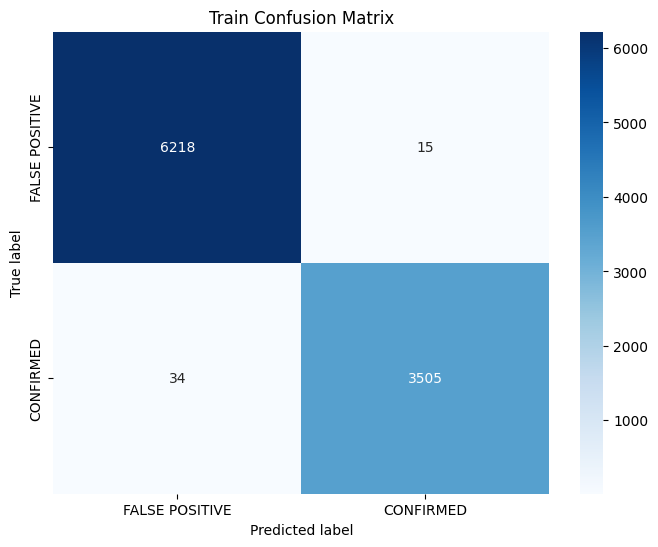

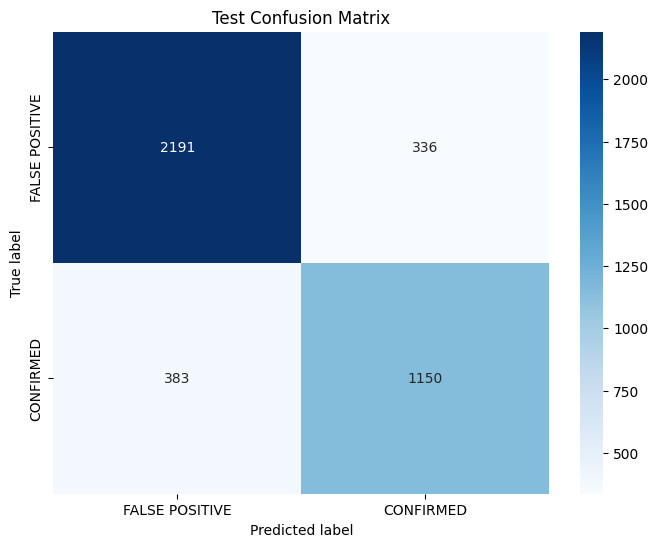

In [53]:

predicted, labels = predict(model, train_loader)
plot_confusion_matrix(labels, predicted, classes, title='Train Confusion Matrix')

predicted, labels = predict(model, test_loader)
plot_confusion_matrix(labels, predicted, classes, title='Test Confusion Matrix')


## Probar el modelo con los datos de CANDIDATOS

In [17]:
global_odd = []
global_even = []
local_odd = []
local_even = []

for lc in tqdm(candidates, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)

items = []
for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global_odd': global_odd[i],
        'global_even': global_even[i],
        'local_odd': local_odd[i],
        'local_even': local_even[i],
        'label': 2       
    }
    items.append(item)

candidates_dataset = torch.utils.data.TensorDataset(torch.tensor([item['global_odd'] for item in items]),
                                                    torch.tensor([item['global_even'] for item in items]),
                                                    torch.tensor([item['local_odd'] for item in items]),
                                                    torch.tensor([item['local_even'] for item in items]),
                                                    torch.tensor([item['label'] for item in items]))
print("Tamaño del conjunto de candidatos:", len(candidates_dataset))

candidates_loader = DataLoader(candidates_dataset, batch_size=batch_size, shuffle=False)

Creating items: 100%|██████████| 2046/2046 [00:00<00:00, 2046636.29it/s]


Tamaño del conjunto de candidatos: 2046


In [18]:
predicted_candidates, _ = predict(model, candidates_loader)


In [19]:
# contar los positivos y negativos
n_positive = sum(predicted_candidates)
n_negative = len(predicted_candidates) - n_positive
print("Exoplanetas confirmados:", n_positive)
print("Falso positivo:", n_negative)

Exoplanetas confirmados: 822
Falso positivo: 968
